In [152]:
import os
from os import listdir
import pandas as pd
import numpy as np
import glob
import tqdm
import gdcm
from typing import Dict
import matplotlib.pyplot as plt
import imageio
import re
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
%matplotlib inline

# Segmentation
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 

import warnings
warnings.filterwarnings("ignore")

#color
from colorama import Fore, Back, Style

import seaborn as sns
sns.set(style="whitegrid")

#pydicom
import pydicom

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# Settings for pretty nice plots
plt.style.use('fivethirtyeight')
plt.show()

In [153]:
IMAGE_PATH = "./input/osic-pulmonary-fibrosis-progression/"

train_df = pd.read_csv('./input/osic-pulmonary-fibrosis-progression/train.csv')
test_df = pd.read_csv('./input/osic-pulmonary-fibrosis-progression/test.csv')

print(Fore.YELLOW + 'Training data shape: ',Style.RESET_ALL,train_df.shape)
train_df.head(5)

Training data shape:   (1549, 7)


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [184]:
test_df

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


In [154]:
#The images are Monochrome
patient19.SamplesPerPixel

1

In [155]:
# https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/

def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    
    # Find the average pixel value near the lungs
        # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0


    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return mask*img

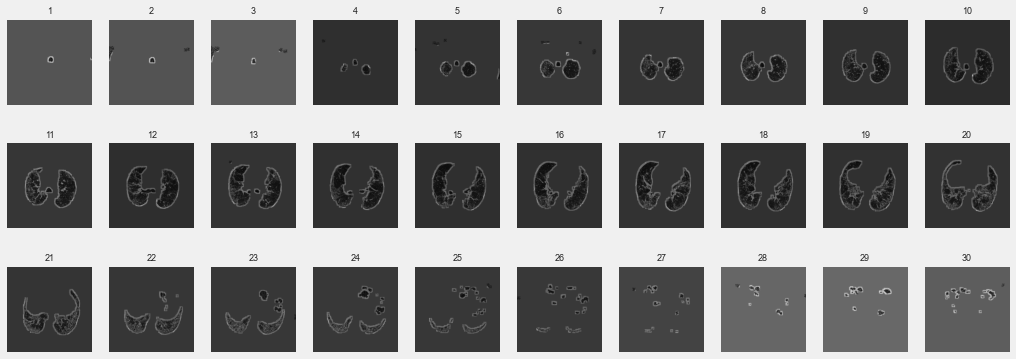

In [156]:
patient_dir = "./input/osic-pulmonary-fibrosis-progression/train/ID00296637202279895784347"
datasets = []

# First Order the files in the dataset
files = []
for dcm in list(os.listdir(patient_dir)):
    files.append(dcm) 
files.sort(key=lambda f: int(re.sub('\D', '', f)))

# Read in the Dataset
for dcm in files:
    path = patient_dir + "/" + dcm
    datasets.append(pydicom.dcmread(path))
    
imgs = []
for data in datasets:
    img = data.pixel_array
    imgs.append(img)
    
    
# Show masks
fig=plt.figure(figsize=(16, 6))
columns = 10
rows = 3

for i in range(1, columns*rows +1):
    img = make_lungmask(datasets[i-1].pixel_array)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap="gray")
    plt.title(i, fontsize = 9)
    plt.axis('off');

In [157]:
count = 0
for patient in list(os.listdir(patients_dir)):
    count += 1
print(count)

176


In [158]:
patients_dir = "./input/osic-pulmonary-fibrosis-progression/train/"
mid_pic = {}

def findMiddle(list):
    l = len(list)//2
    return list[l-5:l+5]

# First Order the files in the dataset
for patient in list(os.listdir(patients_dir)):
    files = []
    for dcm in list(os.listdir(patients_dir+patient)):
        files.append(dcm) 
    files.sort(key=lambda f: int(re.sub('\D', '', f)))
    mid_pic.update({patient:findMiddle(files)})
mid_pic

{'ID00296637202279895784347': ['11.dcm',
  '12.dcm',
  '13.dcm',
  '14.dcm',
  '15.dcm',
  '16.dcm',
  '17.dcm',
  '18.dcm',
  '19.dcm',
  '20.dcm'],
 'ID00032637202181710233084': ['98.dcm',
  '99.dcm',
  '100.dcm',
  '101.dcm',
  '102.dcm',
  '103.dcm',
  '104.dcm',
  '105.dcm',
  '106.dcm',
  '107.dcm'],
 'ID00061637202188184085559': ['122.dcm',
  '123.dcm',
  '124.dcm',
  '125.dcm',
  '126.dcm',
  '127.dcm',
  '128.dcm',
  '129.dcm',
  '130.dcm',
  '131.dcm'],
 'ID00232637202260377586117': ['29.dcm',
  '30.dcm',
  '31.dcm',
  '32.dcm',
  '33.dcm',
  '34.dcm',
  '35.dcm',
  '36.dcm',
  '37.dcm',
  '38.dcm'],
 'ID00322637202284842245491': ['49.dcm',
  '50.dcm',
  '51.dcm',
  '52.dcm',
  '53.dcm',
  '54.dcm',
  '55.dcm',
  '56.dcm',
  '57.dcm',
  '58.dcm'],
 'ID00329637202285906759848': ['126.dcm',
  '127.dcm',
  '128.dcm',
  '129.dcm',
  '130.dcm',
  '131.dcm',
  '132.dcm',
  '133.dcm',
  '134.dcm',
  '135.dcm'],
 'ID00027637202179689871102': ['175.dcm',
  '176.dcm',
  '177.dcm',
  '1

In [159]:
patients_dir_test = "./input/osic-pulmonary-fibrosis-progression/test/"
mid_pic_test = {}

def findMiddle(list):
    l = len(list)//2
    return list[l-5:l+5]

# First Order the files in the dataset
for patient in list(os.listdir(patients_dir_test)):
    files = []
    for dcm in list(os.listdir(patients_dir_test+patient)):
        files.append(dcm) 
    files.sort(key=lambda f: int(re.sub('\D', '', f)))
    mid_pic_test.update({patient:findMiddle(files)})
mid_pic_test

{'ID00426637202313170790466': ['200.dcm',
  '201.dcm',
  '202.dcm',
  '203.dcm',
  '204.dcm',
  '205.dcm',
  '206.dcm',
  '207.dcm',
  '208.dcm',
  '209.dcm'],
 'ID00419637202311204720264': ['10.dcm',
  '11.dcm',
  '12.dcm',
  '13.dcm',
  '14.dcm',
  '15.dcm',
  '16.dcm',
  '17.dcm',
  '18.dcm',
  '19.dcm'],
 'ID00423637202312137826377': ['141.dcm',
  '142.dcm',
  '143.dcm',
  '144.dcm',
  '145.dcm',
  '146.dcm',
  '147.dcm',
  '148.dcm',
  '149.dcm',
  '150.dcm'],
 'ID00422637202311677017371': ['232.dcm',
  '233.dcm',
  '234.dcm',
  '235.dcm',
  '236.dcm',
  '237.dcm',
  '238.dcm',
  '239.dcm',
  '240.dcm',
  '241.dcm'],
 'ID00421637202311550012437': ['27.dcm',
  '28.dcm',
  '29.dcm',
  '30.dcm',
  '31.dcm',
  '32.dcm',
  '33.dcm',
  '34.dcm',
  '35.dcm',
  '36.dcm']}

In [160]:
#check that every patients have 10 slices
for patient, pics in mid_pic.items():
    num = 0
    for pic in pics:
        num+=1
    print(num)

10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10


In [161]:
slices = []
for patient, pics in mid_pic.items():
    for pic in pics:
        path = patients_dir + "/" + patient + "/" + pic
        slices.append(pydicom.dcmread(path))


In [162]:
#Still working
ps = slices[0].PixelSpacing
ss = slices[0].SliceThickness
ax_aspect = ps[1]/ps[0]
sag_aspect = ps[1]/ss
cor_aspect = ss/ps[0]

In [163]:
slices[0].PixelSpacing

[0.714844, 0.714844]

In [164]:
slices[1].PixelSpacing

[0.714844, 0.714844]

In [165]:
img_shape = list([128,128])
img_shape.append(len(slices))
img3d = np.zeros(img_shape)
img3d_test = np.zeros(img_shape)

In [166]:
# pixel_array for this dataset is not the same
for i,s  in enumerate(slices):
    print(list(slices[i].pixel_array.shape))

[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[768, 768]
[768, 768]
[768, 768]
[768, 768]
[768, 768]
[768, 768]
[768, 768]
[768, 768]
[768, 768]
[768, 768]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[768, 768]
[768, 768]
[768, 768]
[768, 768]
[768, 768]
[768, 768]
[768, 768]
[768, 768]
[768, 768]
[768, 768]
[788, 888]

[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[768, 768]
[768, 768]
[768, 768]
[768, 768]
[768, 768]
[768, 768]
[768, 768]
[768, 768]
[768, 768]
[768, 768]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[768, 768]
[768, 768]
[768, 768]
[768, 768]
[768, 768]
[768, 768]
[768, 768]
[768, 768]
[768, 768]
[768, 768]
[768, 768]
[768, 768]
[768, 768]
[768, 768]
[768, 768]
[768, 768]
[768, 768]
[768, 768]
[768, 768]
[768, 768]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]

In [167]:
list(slices[0].pixel_array.shape)

[512, 512]

In [168]:
img3d.shape

(128, 128, 1760)

In [169]:
img_px_size = 128
for i, s in enumerate(slices):
    img2d = s.pixel_array
    img2d = cv2.resize(img2d,(img_px_size,img_px_size))
    img3d[:, :, i] = img2d

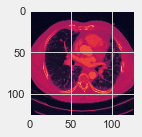

In [170]:
a1 = plt.subplot(2, 2, 1)
plt.imshow(img3d[:, :, img_shape[2]//2])
a1.set_aspect(ax_aspect)

plt.show()

In [176]:
#Test processing
slices_test = []
for patient, pics in mid_pic_test.items():
    for pic in pics:
        path = patients_dir + "/" + patient + "/" + pic
        slices_test.append(pydicom.dcmread(path))

img_shape = list([128,128])
img_shape.append(len(slices_test))
img3d_test = np.zeros(img_shape)
        
img_px_size = 128
for i, s in enumerate(slices_test):
    img2d_test = s.pixel_array
    img2d_test = cv2.resize(img2d_test,(img_px_size,img_px_size))
    img3d_test[:, :, i] = img2d_test


In [177]:
img2d.shape

(128, 128)

In [178]:
img3d.shape

(128, 128, 1760)

In [179]:
img3d_test.shape

(128, 128, 50)

In [180]:
img_input = np.reshape(img3d,[128,128,176,10])
img_input_test = np.reshape(img3d_test,[128,128,5,10])

In [115]:
img_input.shape

(128, 128, 176, 10)

In [182]:
img_input_test.shape

(128, 128, 5, 10)

In [118]:
X = np.swapaxes(img_input,0,2)
X = np.swapaxes(X,1,2)
X.shape

(176, 128, 128, 10)

In [186]:
x_test = np.swapaxes(img_input_test,0,2)
x_test = np.swapaxes(x_test,1,2)
x_test.shape

(5, 128, 128, 10)

In [119]:
label = train_df[['Patient','FVC']]
label2 = label.groupby('Patient').mean()
y= label2['FVC']

In [185]:
label_test = test_df[['Patient','FVC']]
y_test= label_test['FVC']
y_test

0    3020
1    2739
2    1930
3    3294
4    2925
Name: FVC, dtype: int64

In [120]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [121]:
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 117 and 59.


In [124]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv3d_27 (Conv3D)           (None, 126, 126, 62, 64)  1792      
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 63, 63, 31, 64)    0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 63, 63, 31, 64)    256       
_________________________________________________________________
conv3d_28 (Conv3D)           (None, 61, 61, 29, 64)    110656    
_________________________________________________________________
max_pooling3d_22 (MaxPooling (None, 30, 30, 14, 64)    0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 30, 30, 14, 64)    256   

In [126]:
def get_model(width=128, height=128, depth=10):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1)(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=10)
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 128, 128, 10, 1)] 0         
_________________________________________________________________
conv3d_32 (Conv3D)           (None, 126, 126, 8, 64)   1792      
_________________________________________________________________
max_pooling3d_26 (MaxPooling (None, 63, 63, 4, 64)     0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 63, 63, 4, 64)     256       
_________________________________________________________________
global_average_pooling3d_4 ( (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0     

In [128]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .batch(batch_size)
    .prefetch(2)
)

In [189]:
# Compile model.
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="mean_squared_logarithmic_error",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["mse"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 10
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/10
59/59 - 72s - loss: 11.2555 - mse: 7490686.0000 - val_loss: 8.6346 - val_mse: 6747486.0000
Epoch 2/10
59/59 - 71s - loss: 9.1837 - mse: 7306612.5000 - val_loss: 7.8654 - val_mse: 6655774.5000
Epoch 3/10
59/59 - 71s - loss: 7.3411 - mse: 7057794.5000 - val_loss: 6.4995 - val_mse: 6419844.5000
Epoch 4/10
59/59 - 72s - loss: 6.3251 - mse: 6872278.5000 - val_loss: 4.0364 - val_mse: 5798616.0000
Epoch 5/10
59/59 - 72s - loss: 5.2227 - mse: 6588980.0000 - val_loss: 4.2878 - val_mse: 5801699.5000
Epoch 6/10
59/59 - 73s - loss: 4.2879 - mse: 6276914.0000 - val_loss: 4.0125 - val_mse: 5743772.5000
Epoch 7/10
59/59 - 73s - loss: 3.6687 - mse: 6004728.0000 - val_loss: 2.8451 - val_mse: 5216347.0000
Epoch 8/10
59/59 - 71s - loss: 3.0934 - mse: 5698236.0000 - val_loss: 2.3942 - val_mse: 4919331.5000
Epoch 9/10
59/59 - 71s - loss: 2.6876 - mse: 5430517.5000 - val_loss: 2.2080 - val_mse: 4780343.0000
Epoch 10/10
59/59 - 72s - loss: 2.3028 - mse: 5125761.5000 - val_loss: 1.7677 - val_mse: 4

In [190]:
model.predict(x_test)

array([[639.91187],
       [666.1692 ],
       [634.2814 ],
       [700.65735],
       [622.9974 ]], dtype=float32)

In [193]:
# Compile model.
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 10
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/10
59/59 - 72s - loss: 4578160.5000 - root_mean_squared_error: 2139.6636 - val_loss: 3165738.7500 - val_root_mean_squared_error: 1779.2523
Epoch 2/10
59/59 - 71s - loss: 3914112.0000 - root_mean_squared_error: 1978.4115 - val_loss: 2363449.0000 - val_root_mean_squared_error: 1537.3513
Epoch 3/10
59/59 - 71s - loss: 3148901.2500 - root_mean_squared_error: 1774.5144 - val_loss: 2036393.7500 - val_root_mean_squared_error: 1427.0227
Epoch 4/10
59/59 - 71s - loss: 2522238.2500 - root_mean_squared_error: 1588.1556 - val_loss: 1287818.5000 - val_root_mean_squared_error: 1134.8209
Epoch 5/10
59/59 - 70s - loss: 1880043.6250 - root_mean_squared_error: 1371.1469 - val_loss: 1802708.3750 - val_root_mean_squared_error: 1342.6498
Epoch 6/10
59/59 - 71s - loss: 1391395.3750 - root_mean_squared_error: 1179.5742 - val_loss: 1486622.2500 - val_root_mean_squared_error: 1219.2712
Epoch 7/10
59/59 - 70s - loss: 1086494.0000 - root_mean_squared_error: 1042.3502 - val_loss: 870717.6250 - val_root_me

In [194]:
model.predict(x_test)

array([[2633.531 ],
       [2417.737 ],
       [2612.8792],
       [2565.175 ],
       [2577.4524]], dtype=float32)

In [188]:
y_test

0    3020
1    2739
2    1930
3    3294
4    2925
Name: FVC, dtype: int64